# MovieLens 100K: Sistem preporuka zasnovan na uzajamnom filtriranju koristeći matricu kovarijansi

Sistemi preporuka je sistem filtriranja informacija koji pokušava da pretpostavi koju ocenu bi korisnik dao nekom proizvodu u cilju preporučivanja informacija za koje smatra da bi se korisniku svidele. Ovi sistemi su široko rasprostranjeni i korišćeni u različitim sferama života. Postoji više različitih vrsta takvih sistema, ovde će biti korišćen sistem zasnovan na uzajamnom filtriranju. Osnovna ideja uzajamnog filtriranja je da ako su korisnici imali slična interesovanja u prošlosti imaće slična interesovanja i u budućnosti. 

Kako se ocenjuje sličnost među korisnicima? Dosad su korišćenje različite metrike, među kojima su najpopularnije kosinusna funkcija sličnosti, Pirsonov koeficijent korelacije, constrained Pirsonov koeficijent korelacije, Žakardov indeks, razlika srednjih kvadrata, kombinacija razlike srednjih kvadrata i Žakardovog indeksa, itd. Međutim, ovakav pristup uzajamnom filtriranju može imati nekoliko problema:

1) Kvalitet sistema preporuka zasnovanom na uzajamnom filtriranju može umnogome zavisiti od retkosti podataka.

2) Sistem se teško prilagođava situaciji kada se korisnikove preferencije menjaju tokom vremena.

3) Sistem preporučuje slične proizvode korisniku ignorišiću korisnikovu potrebu za raznolikošću.

Zbog navedenih problema preporučen je novi pristup uzajamnom filtriranju koji se zasniva na matrici kovarijansi. Ovaj rad je zasnovan na naučnom radu koji se može pronaći na sledećoj adresi: https://www.hindawi.com/journals/mpe/2018/9740402/

U njemu je predložen algoritam CFCM kojim se rešavaju prethodno navedeni problemi i poboljšava se kvalitet preporuka. Naš zadatak je da implementiramo navedeni algoritam i da evaluiramo njegove performanse.

In [30]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

Koristićemo dostupan skup podataka pod imenom MovieLens u veličini od 100 000. Skup podataka se može naći na: https://grouplens.org/datasets/movielens/100k/

U naučnom radu na kome se zasniva ovaj rad korišćen je skup podataka MovieLens 1M, koji se sastoji od jednog miliona podataka. Sa tim skupom rađeno je u drugoj jupyter svesci, prvo je isproban rad nad ovim skupom zbog hardverskih ograničenja računara, ali i zbog već dostupnih trening i test skupova.

In [31]:
header = ['user', 'item', 'rating', 'timestamp']

Učitavamo ceo skup podataka.

In [32]:
data = pd.read_csv('ml-100k/u.data', sep = '\\t', names = header, engine = 'python')

In [33]:
data.head()

,user,item,rating,timestamp
0,196,242,3,881250949
1,186,302,3,891717742
2,22,377,1,878887116
3,244,51,2,880606923
4,166,346,1,886397596


In [34]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype
---  ------     --------------   -----
 0   user       100000 non-null  int64
 1   item       100000 non-null  int64
 2   rating     100000 non-null  int64
 3   timestamp  100000 non-null  int64
dtypes: int64(4)
memory usage: 3.1 MB


Proveravamo koliko različitih korisnika i filmova imamo.

In [35]:
number_of_users = data['user'].unique().shape[0]
number_of_users

943

In [36]:
number_of_items = data['item'].unique().shape[0]
number_of_items

1682

Formiramo USER-ITEM matricu podataka. Redovi predstavljaju korisnike, a kolone filmove, dok polja matrice odgovaraju ocenama koje je odgovarajući korisnik dao odgovarajućem filmu.

In [37]:
ui_matrix = pd.pivot_table(data, index = 'user', columns = 'item', values = 'rating')

In [38]:
ui_matrix

item,1,2,3,4,5,6,7,8,9,10,...,1673,1674,1675,1676,1677,1678,1679,1680,1681,1682
user,,,,,,,,,,,,,,,,,,,,,
1,5.0,3.0,4.0,3.0,3.0,5.0,4.0,1.0,5.0,3.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,4.0,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
939,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
940,NaN,NaN,NaN,2.0,NaN,NaN,4.0,5.0,3.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
941,5.0,NaN,NaN,NaN,NaN,NaN,4.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [39]:
ui_matrix.describe()

item,1,2,3,4,5,6,7,8,9,10,...,1673,1674,1675,1676,1677,1678,1679,1680,1681,1682
count,452.000000,131.000000,90.000000,209.000000,86.000000,26.000000,392.000000,219.000000,299.000000,89.000000,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
mean,3.878319,3.206107,3.033333,3.550239,3.302326,3.576923,3.798469,3.995434,3.896321,3.831461,...,3.0,4.0,3.0,2.0,3.0,1.0,3.0,2.0,3.0,3.0
std,0.927897,0.966497,1.212760,0.965069,0.946446,1.301478,0.982037,1.002281,1.042368,1.013948,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
min,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,3.0,4.0,3.0,2.0,3.0,1.0,3.0,2.0,3.0,3.0
25%,3.000000,3.000000,2.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,...,3.0,4.0,3.0,2.0,3.0,1.0,3.0,2.0,3.0,3.0
50%,4.000000,3.000000,3.000000,4.000000,3.000000,4.000000,4.000000,4.000000,4.000000,4.000000,...,3.0,4.0,3.0,2.0,3.0,1.0,3.0,2.0,3.0,3.0
75%,5.000000,4.000000,4.000000,4.000000,4.000000,5.000000,5.000000,5.000000,5.000000,5.000000,...,3.0,4.0,3.0,2.0,3.0,1.0,3.0,2.0,3.0,3.0
max,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,...,3.0,4.0,3.0,2.0,3.0,1.0,3.0,2.0,3.0,3.0


Možemo videti da je USER-ITEM matrica veoma retka što potpada pod jedan od navedenih problema.

Učitavamo dostupne trening podatke.

In [40]:
train_data = pd.read_csv('ml-100k/u1.base', sep = '\\t', names = header, engine = 'python')

In [41]:
train_data.head()

,user,item,rating,timestamp
0,1,1,5,874965758
1,1,2,3,876893171
2,1,3,4,878542960
3,1,4,3,876893119
4,1,5,3,889751712


In [84]:
train_data.shape

(80000, 4)

Učitavamo dostupne test podatke koji odgovaraju učitanim trening podacima.

In [42]:
test_data = pd.read_csv('ml-100k/u1.test', sep = '\\t', names = header, engine = 'python')

In [43]:
test_data.head()

,user,item,rating,timestamp
0,1,6,5,887431973
1,1,10,3,875693118
2,1,12,5,878542960
3,1,14,5,874965706
4,1,17,3,875073198


### Vizualiazacija podataka

In [93]:
genres = pd.read_csv('ml-100k/u.genre', sep = '|', names=['genre', 'id'], engine = 'python')

In [44]:
movies_header = ['item', 'title', 'date1', 'date2', 'url'] + [g for g in genres['genre']]

In [45]:
movies_header

['item',
 'title',
 'date1',
 'date2',
 'url',
 'unknown',
 'Action',
 'Adventure',
 'Animation',
 "Children's",
 'Comedy',
 'Crime',
 'Documentary',
 'Drama',
 'Fantasy',
 'Film-Noir',
 'Horror',
 'Musical',
 'Mystery',
 'Romance',
 'Sci-Fi',
 'Thriller',
 'War',
 'Western']

In [63]:
movies = pd.read_csv('ml-100k/u.item', sep = '|', names = movies_header, engine = 'python')

In [64]:
movies.head()

,item,title,date1,date2,url,unknown,Action,Adventure,Animation,Children's,...,Fantasy,Film-Noir,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
0,1,Toy Story (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Toy%20Story%2...,0,0,0,1,1,...,0,0,0,0,0,0,0,0,0,0
1,2,GoldenEye (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?GoldenEye%20(...,0,1,1,0,0,...,0,0,0,0,0,0,0,1,0,0
2,3,Four Rooms (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Four%20Rooms%...,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
3,4,Get Shorty (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Get%20Shorty%...,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,5,Copycat (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Copycat%20(1995),0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0


In [65]:
del movies['date1']
del movies['date2']
del movies['url']
movies.head()

,item,title,unknown,Action,Adventure,Animation,Children's,Comedy,Crime,Documentary,...,Fantasy,Film-Noir,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
0,1,Toy Story (1995),0,0,0,1,1,1,0,0,...,0,0,0,0,0,0,0,0,0,0
1,2,GoldenEye (1995),0,1,1,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
2,3,Four Rooms (1995),0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
3,4,Get Shorty (1995),0,1,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
4,5,Copycat (1995),0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,1,0,0


In [66]:
train_data_movies = pd.merge(train_data, movies, on = 'item')

In [67]:
train_data_movies.head()

,user,item,rating,timestamp,title,unknown,Action,Adventure,Animation,Children's,...,Fantasy,Film-Noir,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
0,1,1,5,874965758,Toy Story (1995),0,0,0,1,1,...,0,0,0,0,0,0,0,0,0,0
1,2,1,4,888550871,Toy Story (1995),0,0,0,1,1,...,0,0,0,0,0,0,0,0,0,0
2,6,1,4,883599478,Toy Story (1995),0,0,0,1,1,...,0,0,0,0,0,0,0,0,0,0
3,13,1,3,882140487,Toy Story (1995),0,0,0,1,1,...,0,0,0,0,0,0,0,0,0,0
4,16,1,5,877717833,Toy Story (1995),0,0,0,1,1,...,0,0,0,0,0,0,0,0,0,0


In [69]:
train_data_movies.groupby('title')['rating'].mean().sort_values(ascending=False).head(10)

title
Marlene Dietrich: Shadow and Light (1996)            5.000000
Prefontaine (1997)                                   5.000000
Someone Else's America (1995)                        5.000000
They Made Me a Criminal (1939)                       5.000000
Saint of Fort Washington, The (1993)                 5.000000
Santa with Muscles (1996)                            5.000000
Star Kid (1997)                                      5.000000
Entertaining Angels: The Dorothy Day Story (1996)    5.000000
Pather Panchali (1955)                               4.714286
Faust (1994)                                         4.666667
Name: rating, dtype: float64

In [70]:
train_data_movies.groupby('title')['rating'].count().sort_values(ascending=False).head(10)

title
Star Wars (1977)                 484
Return of the Jedi (1983)        422
Contact (1997)                   402
Fargo (1996)                     395
Liar Liar (1997)                 394
Scream (1996)                    391
English Patient, The (1996)      388
Toy Story (1995)                 383
Independence Day (ID4) (1996)    353
Air Force One (1997)             352
Name: rating, dtype: int64

In [71]:
ratings = pd.DataFrame(train_data_movies.groupby('title')['rating'].mean())
ratings['count'] = pd.DataFrame(train_data_movies.groupby('title')['rating'].count())
ratings = pd.merge(ratings, movies, on='title')
ratings.sort_values(by='count', ascending=False).head(10)

,title,rating,count,item,unknown,Action,Adventure,Animation,Children's,Comedy,...,Fantasy,Film-Noir,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
1388,Star Wars (1977),4.359504,484,50,0,1,1,0,0,0,...,0,0,0,0,0,1,1,0,1,0
1223,Return of the Jedi (1983),4.011848,422,181,0,1,1,0,0,0,...,0,0,0,0,0,1,1,0,1,0
334,Contact (1997),3.823383,402,258,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
497,Fargo (1996),4.108861,395,100,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
855,Liar Liar (1997),3.164975,394,294,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
1273,Scream (1996),3.445013,391,288,0,0,0,0,0,0,...,0,0,1,0,0,0,0,1,0,0
461,"English Patient, The (1996)",3.641753,388,286,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,1,0
1513,Toy Story (1995),3.892950,383,1,0,0,0,1,1,1,...,0,0,0,0,0,0,0,0,0,0
741,Independence Day (ID4) (1996),3.390935,353,121,0,1,0,0,0,0,...,0,0,0,0,0,0,1,0,1,0
31,Air Force One (1997),3.656250,352,300,0,1,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0


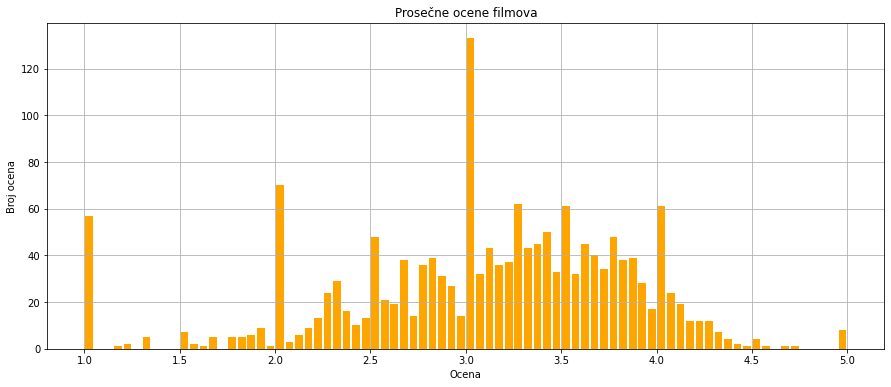

In [72]:
plt.figure(figsize=(15, 6))
ratings['rating'].hist(bins=80, rwidth=0.8, color='orange')
plt.xlabel('Ocena')
plt.ylabel('Broj ocena')
plt.title('Prosečne ocene filmova')
plt.show()

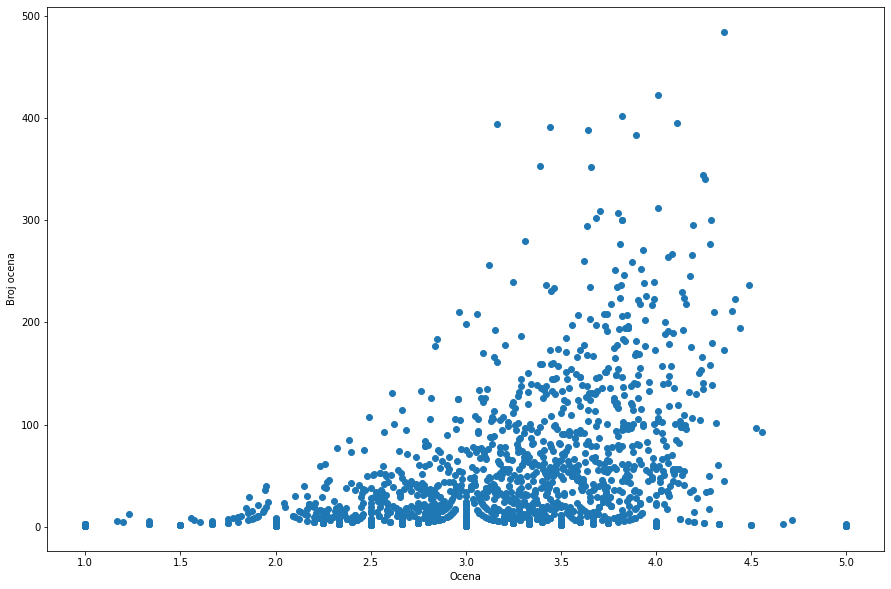

In [73]:
plt.figure(figsize=(15, 10))
plt.scatter(x = ratings['rating'], y = ratings['count'])
plt.xlabel('Ocena')
plt.ylabel('Broj ocena')
plt.show()

In [81]:
number_of_ratings_for_genre = {}
for x in genres['genre']:
    number_of_ratings_for_genre[x] = len(np.where(np.array(train_data_movies[x]) == 1)[0])

In [91]:
number_of_ratings_for_genre

{'unknown': 3,
 'Action': 20566,
 'Adventure': 11131,
 'Animation': 2893,
 "Children's": 5779,
 'Comedy': 23896,
 'Crime': 6446,
 'Documentary': 570,
 'Drama': 31989,
 'Fantasy': 1090,
 'Film-Noir': 1394,
 'Horror': 4187,
 'Musical': 3966,
 'Mystery': 4208,
 'Romance': 15547,
 'Sci-Fi': 10241,
 'Thriller': 17438,
 'War': 7613,
 'Western': 1480}

In [100]:
average_ratings_for_genres = []

for x in genres['genre']:
    average_ratings_for_genres.append(ratings[ratings[x].apply(lambda y: y == 1)].mean().rating)

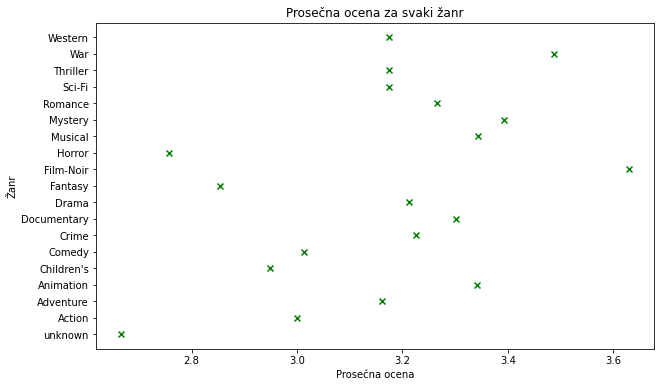

In [101]:
plt.figure(figsize=(10, 6))
plt.scatter(x = average_ratings_for_genres, y = [g for g in genres['genre']], color='green', marker='x')
plt.ylabel('Žanr')
plt.xlabel('Prosečna ocena')
plt.title('Prosečna ocena za svaki žanr')
plt.show()

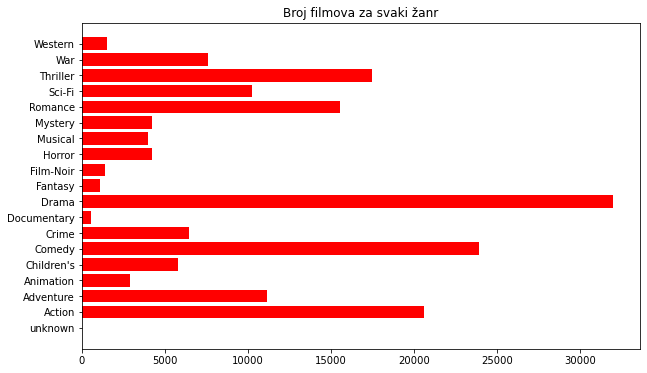

In [102]:
plt.figure(figsize=(10, 6))
plt.barh([g for g in genres['genre']], list(number_of_ratings_for_genre.values()), color='red')
plt.title('Broj filmova za svaki žanr')
plt.show()

### Rad sa podacima

Formiramo USER-ITEM matricu nad trening podacima (na drugačiji način nego nad svim podacima, zbog toga što u trening podacima se ne nalaze svi filmovi, a nama je potrebno da ih imamo u toj matrici pa ih dodajemo ovde sa svim vrednostima 0 u matrici).

In [18]:
ui_matrix_train = np.zeros((number_of_users, number_of_items))
for row in train_data.itertuples():
    ui_matrix_train[row[1]-1, row[2]-2] = row[3]
    
ui_matrix_train.shape

(943, 1682)

In [19]:
ui_matrix_train

array([[3., 4., 3., ..., 0., 0., 5.],
       [0., 0., 0., ..., 0., 0., 4.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 5.],
       [0., 0., 0., ..., 0., 0., 0.],
       [5., 0., 0., ..., 0., 0., 0.]])

Ukupno svih filmova imamo 1682, a u trening skupu ih imamo 1650.

In [459]:
number_of_items

1682

In [20]:
train_data['item'].unique().shape[0]

1650

Broj različitih korisnika u trening skupu.

In [460]:
train_data['user'].unique().shape[0]

943

Broj različitih korisnika u test skupu.

In [461]:
test_data['user'].unique().shape[0]

459

Računamo vrednost kovarijanse između dva korisnika na osnovu sledeće formule:

$ cov(u_{i}, u_{j}) = $ 

In [24]:
def calculate_covariance_between_users(ui_matrix, i, j):
    if (i != j):
        ratings_i = ui_matrix[i,:]
        ratings_j = ui_matrix[j,:]
    
        common_items = (ratings_i != 0) & (ratings_j != 0)
    
        part1 = np.sum(ratings_i[common_items]*ratings_j[common_items])*(1/number_of_items)
        part2 = np.sum(ratings_i)*np.sum(ratings_j)*(1/(number_of_items**2))
    
        return part1 - part2
    else:
        return float('inf')

In [25]:
calculate_covariance_between_users(ui_matrix_train, 1, 2)

0.008566609310867957

In [26]:
calculate_covariance_between_users(ui_matrix_train, 2, 1)

0.008566609310867957

In [27]:
calculate_covariance_between_users(ui_matrix_train, 100, 99)

-0.004150401325640022

Formiramo matricu kovarijanse za svaka dva korisnika koristeći prethodno definisanu funkciju koja računa kovarijansu između dva korisnika. S obzirom na to da je matrica simetrična, dovoljno je računati samo pola matrice.

In [28]:
covariance_matrix = np.zeros((number_of_users, number_of_users))
for i in range(number_of_users):
    for j in range(i, number_of_users):
        covariance_matrix[i, j] = calculate_covariance_between_users(ui_matrix_train, i, j)
        covariance_matrix[j, i] = covariance_matrix[i, j]

In [29]:
covariance_matrix

array([[        inf,  0.03810155,  0.00961923, ...,  0.06700484,
         0.07872932,  0.21979136],
       [ 0.03810155,         inf,  0.00856661, ...,  0.03326825,
         0.05383221,  0.03996361],
       [ 0.00961923,  0.00856661,         inf, ...,  0.01400433,
         0.02209871, -0.00750055],
       ...,
       [ 0.06700484,  0.03326825,  0.01400433, ...,         inf,
         0.03458279,  0.03369842],
       [ 0.07872932,  0.05383221,  0.02209871, ...,  0.03458279,
                inf,  0.12853484],
       [ 0.21979136,  0.03996361, -0.00750055, ...,  0.03369842,
         0.12853484,         inf]])

In [30]:
covariance_matrix[10, 20]

0.008439714908218932

In [31]:
covariance_matrix[20, 10]

0.008439714908218932

In [32]:
covariance_matrix[942, 0]

0.21979135591087556

In [33]:
covariance_matrix[0, 942]

0.21979135591087556

Definišemo funkciju koja vraća K najličnijih korisnika korisniku koji se prosleđuje kao argument.

In [34]:
def GetKSimilarUser(user_i, K):
    user_values = covariance_matrix[user_i,:]
    values = user_values.argsort()[-K-1:]
    
    return values[0:K]

In [35]:
print(GetKSimilarUser(0, 10))
for i in GetKSimilarUser(0,10):
    print(covariance_matrix[0, i])

[415 888 746 605 456 513 473 822 863 591]
0.4247661113475408
0.43463771824776853
0.44647318392548363
0.44853106473947413
0.4494610345817291
0.45235804439819527
0.47118436660959356
0.4804091301759837
0.49576618062693606
0.5263399554066912


Definišemo funkciju koja vraća K najrazličitijih korisnika korisniku koji se prosleđuje kao argument.

In [36]:
def GetKDSimilarUser(user_i, K):
    user_values = covariance_matrix[user_i,:]
    
    return user_values.argsort()[:K]

Formiramo niz koji za svakog korisnika iz trening skupa sadrži prosek ocena koje je dao filmovima koje je gledao.

In [293]:
train_users = train_data['user'].unique()
average_ratings = np.zeros(number_of_users)

for user in train_users:
    average_ratings[user-1] = ui_matrix_train[user-1, ui_matrix_train[user-1, :] != 0].mean()
    
average_ratings
    

array([3.68148148, 3.8       , 3.        , 4.35714286, 2.95604396,
       3.58181818, 3.89201878, 3.6       , 4.16666667, 4.21276596,
       3.53333333, 4.28      , 3.13672922, 4.2195122 , 3.03333333,
       4.34782609, 3.15789474, 3.93710692, 3.6       , 3.30769231,
       2.66315789, 3.3       , 3.63636364, 4.3902439 , 4.04878049,
       2.90909091, 3.3       , 3.64102564, 3.94117647, 3.8       ,
       3.91304348, 3.54545455, 3.64285714, 3.8       , 3.        ,
       4.        , 3.45945946, 3.9047619 , 3.84615385, 2.72727273,
       3.93548387, 3.625     , 3.67857143, 3.6375    , 3.48275862,
       4.18181818, 3.5625    , 3.72727273, 2.72897196, 3.53846154,
       3.75      , 4.34285714, 4.        , 3.33333333, 3.8       ,
       3.65217391, 3.62962963, 3.875     , 4.02325581, 4.13445378,
       2.83333333, 3.31707317, 2.97916667, 3.59633028, 3.97916667,
       3.52380952, 3.41666667, 3.16666667, 3.73684211, 3.4025974 ,
       3.81818182, 3.76712329, 3.64705882, 3.76190476, 3.18181

Predloženi algoritam

In [464]:
def CFCM(UI, user_u, alpha, K, N):
    Nus = GetKSimilarUser(user_u-1, K)
    Nud = GetKDSimilarUser(user_u-1, K)
    
    # pronalazimo iteme koje korisnik nije ocenio i nad njima primenjujemo algoritam
    unrated_items = np.where(UI[user_u-1, :] == 0)[0]
    number_of_unrated_items = unrated_items.shape[0]
    # rečnik predvidjenih ocena za sve iteme
    all_predicted_ratings = {}
    # drugo, krace ime za matricu kovarijansi
    COV = covariance_matrix
    
    
    for item_i in unrated_items:
        
        # za racunanje dela iznad razlomacke crte u prvom delu gde se posmatraju slicni
        similar = np.zeros(K)
        # za racunanje dela ispod razlomacke crte u prvom delu gde se posmatraju slicni
        divide_s = np.zeros(K)
        # za racunanje dela iznad razlomacke crte u drugom delu gde se posmatraju razliciti
        disimilar = np.zeros(K)
        # za racunanje dela ispod razlomacke crte u drugom delu gde se posmatraju razliciti
        divide_ds = np.zeros(K)
    
        for i in range(K):
            similar[i] = COV[user_u-1, Nus[i]]*(UI[Nus[i],item_i] - average_ratings[Nus[i]])
            divide_s[i] = np.abs(COV[user_u-1, Nus[i]])
            disimilar[i] = np.abs(COV[user_u-1, Nud[i]])*(UI[Nud[i],item_i] - average_ratings[Nud[i]])
            divide_ds[i] = np.abs(COV[user_u-1, Nud[i]])
        
        # formula iz algoritma
        rui = average_ratings[user_u-1] + alpha * (np.sum(similar)/np.sum(divide_s)) + (1-alpha) * (np.sum(disimilar)/np.sum(divide_ds))
        # za svaki element stavljamo u niz
        all_predicted_ratings[item_i] = rui
        #print(rui) 
        
    # uzimamo prvih N najboljih predloga za usera u     
    sorted_ratings = sorted(all_predicted_ratings.items(), key=lambda x: x[1], reverse=True)
    sorted_i = [rating[0] for rating in sorted_ratings[:N]]
    sorted_r = [rating[1] for rating in sorted_ratings[:N]]
    
    # rezultat je lista parova itema i njihovih ocena
    Result = list(zip(sorted_i, sorted_r))
    return Result

In [301]:
CFCM(ui_matrix_train, 200, 0.8, 10, 5)

[(172, 4.2870704319383055),
 (48, 4.132586341708102),
 (80, 4.064823508159774),
 (179, 3.9695336703784125),
 (94, 3.9000457126344017)]

In [302]:
CFCM(ui_matrix_train, 1, 0.8, 10, 5)

[(96, 3.759914892335842),
 (421, 3.686520019266224),
 (98, 3.681752439250074),
 (94, 3.522095216899382),
 (95, 3.508205710685873)]

Proba jedna

In [324]:
def CFCM_update(UI, user_u, alpha, K, N):
    Nus = GetKSimilarUser(user_u-1, K)
    Nud = GetKDSimilarUser(user_u-1, K)
    
    # prosecna ocena koju je dao user, izracunata samo nad itemima koji nisu 0
    # ru_average = UI[user_u-1, UI[user_u-1, :] != 0].mean()
    unrated_items = np.where(UI[user_u-1, :] == 0)[0]
    number_of_unrated_items = unrated_items.shape[0]
    # niz predvidjenih ocena za sve iteme
    all_predicted_ratings = {}
    # drugo, krace ime za matricu kovarijansi
    COV = covariance_matrix
    
    
    for item_i in unrated_items:
        
        similar = [COV[user_u-1, similar_user]*(UI[similar_user, item_i] - average_ratings[similar_user]) for similar_user in Nus]
        divide_similar = [np.abs(COV[user_u-1, similar_user]) for similar_user in Nus]
        disimilar = [np.abs(COV[user_u-1, disim_user])*(UI[disim_user, item_i] - average_ratings[disim_user]) for disim_user in Nud]
        divide_disimilar = [np.abs(COV[user_u-1, disim_user]) for disim_user in Nud]

        # formula iz algoritma
        rui = average_ratings[user_u-1] + alpha * (np.sum(similar)/np.sum(divide_similar)) + (1-alpha) * (np.sum(disimilar)/np.sum(divide_disimilar))
        # za svaki element stavljamo u niz
        all_predicted_ratings[item_i+1] = rui
        #print(rui) 
        
        #if (item_i == 173):
            #print(all_predicted_ratings[item_i])
        
    # uzimamo prvih N najboljih predloga za usera u     
    sorted_ratings = sorted(all_predicted_ratings.items(), key=lambda x: x[1], reverse=True)
    sorted_i = [rating[0] for rating in sorted_ratings[:N]]
    sorted_r = [rating[1] for rating in sorted_ratings[:N]]
    Result = list(zip(sorted_i, sorted_r))
    return Result

In [325]:
CFCM_update(ui_matrix_train, 200, 0.8, 10, 5)

[(173, 4.2870704319383055),
 (49, 4.132586341708102),
 (81, 4.064823508159774),
 (180, 3.9695336703784125),
 (95, 3.9000457126344017)]

In [465]:
CFCM_update(ui_matrix_train, 1, 0.8, 10, 5) # proba je uspesna

[(97, 3.759914892335842),
 (422, 3.686520019266224),
 (99, 3.681752439250074),
 (95, 3.522095216899382),
 (96, 3.508205710685873)]

Definišemo funkciju koja primenjuje naš algoritam za dato alfa, K i N.

In [331]:
def recommendToTestUsers(alpha, K, N):
    users = test_data['user'].unique()
    
    R = {}
    
    for user in users:
        R[user] = CFCM(ui_matrix_train, user, alpha = alpha, K = K, N = N)
        
    return R

In [466]:
R = recommendToTestUsers(0.8, 30, 20) # proba primene algoritma

In [467]:
R

{1: [(96, 3.6939921497836172),
  (172, 3.631105149555374),
  (94, 3.4311445655120334),
  (10, 3.395223284873561),
  (98, 3.3909099865326393),
  (181, 3.295439753015497),
  (54, 3.2489433527037077),
  (421, 3.0830894085139855),
  (256, 3.072001214205419),
  (62, 3.0027518125003736),
  (67, 2.910145158121182),
  (653, 2.8941131486659177),
  (200, 2.8908767938440016),
  (208, 2.845025271914923),
  (194, 2.7922126614570697),
  (316, 2.7549239336387474),
  (207, 2.724777381733052),
  (226, 2.710538416819676),
  (178, 2.634161181797695),
  (184, 2.6292350889994287)],
 2: [(48, 4.155767522873121),
  (311, 3.172810476987165),
  (5, 3.060972283334395),
  (179, 3.0365386217248225),
  (122, 2.9310540126744073),
  (115, 2.7314251650994246),
  (473, 2.68328967310853),
  (589, 2.573797971257179),
  (331, 2.5698830864846025),
  (119, 2.5575248159535477),
  (7, 2.4960822718408657),
  (469, 2.4449068907303086),
  (255, 2.4285101251794634),
  (296, 2.3894615968177626),
  (403, 2.386236142399307),
  (740

Za svakog test korisnika vraćamo filmove koje je gledao i ocene koje im je dao.

In [468]:
def getTestItems():
    test_users = test_data['user'].unique()
    T = {}
    for test_user in test_users:
        T[test_user] = list(zip(np.array(test_data[test_data['user'] == test_user]['item']), np.array(test_data[test_data['user'] == test_user]['rating'])))

    return T

In [469]:
T = getTestItems()

In [470]:
T

{1: [(6, 5),
  (10, 3),
  (12, 5),
  (14, 5),
  (17, 3),
  (20, 4),
  (23, 4),
  (24, 3),
  (27, 2),
  (31, 3),
  (33, 4),
  (36, 2),
  (39, 4),
  (44, 5),
  (47, 4),
  (49, 3),
  (51, 4),
  (53, 3),
  (54, 3),
  (56, 4),
  (60, 5),
  (61, 4),
  (62, 3),
  (64, 5),
  (65, 4),
  (67, 3),
  (69, 3),
  (70, 3),
  (72, 4),
  (73, 3),
  (74, 1),
  (76, 4),
  (78, 1),
  (80, 4),
  (81, 5),
  (82, 5),
  (84, 4),
  (85, 3),
  (86, 5),
  (90, 4),
  (91, 5),
  (92, 3),
  (96, 5),
  (97, 3),
  (98, 4),
  (100, 5),
  (102, 2),
  (103, 1),
  (104, 1),
  (107, 4),
  (108, 5),
  (112, 1),
  (113, 5),
  (114, 5),
  (117, 3),
  (118, 3),
  (120, 1),
  (121, 4),
  (125, 3),
  (128, 4),
  (129, 5),
  (130, 3),
  (132, 4),
  (134, 4),
  (140, 1),
  (143, 1),
  (145, 2),
  (148, 2),
  (150, 5),
  (151, 4),
  (154, 5),
  (155, 2),
  (157, 4),
  (159, 3),
  (160, 4),
  (161, 4),
  (163, 4),
  (164, 3),
  (170, 5),
  (171, 5),
  (174, 5),
  (175, 5),
  (177, 5),
  (180, 3),
  (183, 5),
  (184, 4),
  (185, 4),

In [471]:
test_data

,user,item,rating,timestamp
0,1,6,5,887431973
1,1,10,3,875693118
2,1,12,5,878542960
3,1,14,5,874965706
4,1,17,3,875073198
...,...,...,...,...
19995,458,648,4,886395899
19996,458,1101,4,886397931
19997,459,934,3,879563639
19998,460,10,3,882912371


Definišemo funkciju za računanje preciznosti nad izlazom algoritma i test skupom.

In [431]:
def getPrecision(R, T):
    test_users = test_data['user'].unique()
    number_of_test_users = test_data['user'].unique().shape[0]
    
    A = np.zeros(number_of_test_users)
    B = np.zeros(number_of_test_users)
    i = 0
    for test_user in test_users:
        A[i] = len(set([T[test_user][i][0] for i in range(len(T[test_user]))]) & set([R[test_user][i][0] for i in range(len(R[test_user]))]))
        B[i] = len(R[test_user])
        i = i + 1
        
    Precision = np.sum(A)/np.sum(B)
    
    return Precision

Definišemo funkciju za računanje odziva nad izlazom algoritma i test skupom.

In [432]:
def getRecall(R, T):
    test_users = test_data['user'].unique()
    number_of_test_users = test_data['user'].unique().shape[0]
    
    A = np.zeros(number_of_test_users)
    B = np.zeros(number_of_test_users)
    i = 0
    for test_user in test_users:
        A[i] = len(set([T[test_user][i][0] for i in range(len(T[test_user]))]) & set([R[test_user][i][0] for i in range(len(R[test_user]))]))
        B[i] = len(T[test_user])
        i = i + 1
        
    Recall = np.sum(A)/np.sum(B)
    
    return Recall

Za svakog korisnika računamo minimalnu i maksimalnu ocenu koju je dao u trening skupu.

In [449]:
min_max_rating = {}
for i in range(number_of_users):
    min_rating = ui_matrix_train[i, ui_matrix_train[i, :] != 0].min()
    max_rating = ui_matrix_train[i, ui_matrix_train[i, :] != 0].max()
    min_max_rating[i] = [min_rating, max_rating]
    
min_max_rating

{0: [1.0, 5.0],
 1: [1.0, 5.0],
 2: [1.0, 5.0],
 3: [2.0, 5.0],
 4: [1.0, 5.0],
 5: [1.0, 5.0],
 6: [1.0, 5.0],
 7: [1.0, 5.0],
 8: [1.0, 5.0],
 9: [3.0, 5.0],
 10: [1.0, 5.0],
 11: [3.0, 5.0],
 12: [1.0, 5.0],
 13: [1.0, 5.0],
 14: [1.0, 5.0],
 15: [1.0, 5.0],
 16: [1.0, 5.0],
 17: [2.0, 5.0],
 18: [2.0, 5.0],
 19: [1.0, 5.0],
 20: [1.0, 5.0],
 21: [1.0, 5.0],
 22: [1.0, 5.0],
 23: [3.0, 5.0],
 24: [3.0, 5.0],
 25: [1.0, 5.0],
 26: [2.0, 5.0],
 27: [2.0, 5.0],
 28: [2.0, 5.0],
 29: [1.0, 5.0],
 30: [2.0, 5.0],
 31: [2.0, 5.0],
 32: [3.0, 4.0],
 33: [1.0, 5.0],
 34: [1.0, 5.0],
 35: [2.0, 5.0],
 36: [1.0, 5.0],
 37: [1.0, 5.0],
 38: [2.0, 5.0],
 39: [1.0, 4.0],
 40: [2.0, 5.0],
 41: [1.0, 5.0],
 42: [1.0, 5.0],
 43: [1.0, 5.0],
 44: [2.0, 5.0],
 45: [3.0, 5.0],
 46: [2.0, 5.0],
 47: [1.0, 5.0],
 48: [1.0, 5.0],
 49: [1.0, 5.0],
 50: [1.0, 5.0],
 51: [3.0, 5.0],
 52: [2.0, 5.0],
 53: [1.0, 5.0],
 54: [2.0, 5.0],
 55: [1.0, 5.0],
 56: [1.0, 5.0],
 57: [1.0, 5.0],
 58: [1.0, 5.0],
 59: [3

Definišemo funkciju za računanje metrika MAE i NMAE.

In [472]:
def getMAEandNMAE(R, T):
    
    test_users = test_data['user'].unique()
    number_of_test_users = test_data['user'].unique().shape[0]
    MAE_one_user = []
    NMAE_one_user = []
    MAE_all = []
    NMAE_all = []
    
    for test_user in test_users:
        common_items = set([T[test_user][i][0] for i in range(len(T[test_user]))]) & set([R[test_user][i][0] for i in range(len(R[test_user]))])
        n = len(common_items)
        
        if (n != 0):
            for common_item in common_items:
                item_index_T = np.where(np.array([T[test_user][i][0] for i in range(len(T[test_user]))]) == common_item)[0][0]
                item_index_R = np.where(np.array([R[test_user][i][0] for i in range(len(R[test_user]))]) == common_item)[0][0]
                item_rating_T = T[test_user][item_index_T][1]
                item_rating_R = R[test_user][item_index_R][1]
                MAE_one_user.append(np.abs(item_rating_T - item_rating_R))
                NMAE_one_user.append(np.abs(item_rating_T - item_rating_R))
            
            MAE_all.append(np.array(MAE_one_user).sum()/n)
            t = 1 / (min_max_rating[test_user - 1][1] - min_max_rating[test_user - 1][0])
            NMAE_all.append(t * np.array(MAE_one_user).sum()/n)
        
    MAE = np.array(MAE_all).mean()
    NMAE = np.array(NMAE_all).mean()
    
    MAE_and_NMAE = [MAE, NMAE]
    
    return MAE_and_NMAE
            
        

Primenjujemo algoritam za različite vrednosti parametara i pamtimo evaluacije za svaku od tih kombinacija parametara.

In [453]:
def applyAlgorithm():
    T = getTestItems()
    alphas = [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]
    F1s = []
    MAEs = []
    NMAEs = []
    for alpha in alphas:
        print(alpha)
        R = recommendToTestUsers(alpha = alpha, K = 5, N = 5)
        precision = getPrecision(R, T)
        recall = getRecall(R, T)
        F1 = 2 / (1/precision + 1/recall)
        F1s.append(F1)
        MAE_and_NMAE = getMAEandNMAE(R, T)
        MAEs.append(MAE_and_NMAE[0])
        NMAEs.append(MAE_and_NMAE[1])
        
    evaluations = list(zip(alphas, F1s, MAEs, NMAEs))
    
    return evaluations
        
    

In [454]:
evaluations = applyAlgorithm()
evaluations

0
0
0
0
0
0
0
0
0
0
0
0
0
2
0
0
0
0
1
0
0
0
0
0
0
0
0
0
0
0
1
0
0
0
0
0
0
0
0
0
0
0
0
2
1
0
0
0
0
0
0
0
0
0
0
0
1
0
0
0
0
0
2
0
2
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
3
0
0
0
0
1
0
0
0
0
0
0
0
0
1
1
0
2
0
0
0
1
0
0
0
0
0
0
0
0
0
1
1
1
0
0
0
0
2
0
0
0
0
0
0
1
0
0
0
0
2
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
1
0
0
0
0
0
1
0
0
1
0
0
0
0
0
0
0
0
0
0
0
0
0
0
1
0
0
0
0
0
0
0
1
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
2
0
0
1
0
0
0
0
0
1
1
0
1
0
2
0
0
1
0
0
0
0
0
1
0
0
0
0
0
0
0
1
1
0
0
0
0
0
0
0
0
0
1
0
0
1
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
3
0
0
0
1
0
0
0
0
0
1
0
0
0
0
1
0
0
0
0
1
1
1
1
0
1
0
3
0
0
0
0
0
0
0
0
0
0
0
0
0
0
1
0
2
0
1
1
0
0
0
0
0
0
0
0
0
0
1
0
0
0
0
0
0
0
0
0
1
2
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
1
0
1
0
0
0
0
1
0
0
0
0
0
0
0
0
0
1
0
0
0
0
0
0
0
0
0
0
0
0
0
1
1
0
0
0
0
0
1
0
0
0
0
0
0
0
0
0
1
0
0
0
0
0
0
0
0
0
0
0
1
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0.1
0
0
0
0
0
0
0
0
0
0
0
0
2
0
0
0
0
1
0
0
0
0
0
0
0
0
0
0
0
1
0
0
0
0
0
0
0
0


3
0
0
0
2
1
3
0
0
1
0
0
0
1
0
0
0
1
0
0
0
1
0
0
0
2
0
0
1
0
0
1
0
0
0
0
0
1
0
0
0
0
1
2
0
0
1
1
0
1
0
0
0
0
0
4
0
1
2
2
0
0
0
0
1
0
0
0
1
1
1
0
0
0
0
1
1
0
0
0
0
0
1
0
2
0
1
0
0
2
1
2
1
0
1
0
0
0
0
0
0
2
0
0
0
1
1
0
1
1
0
0
0
0
0
1
0
0
0
0
0
0
0
0
2
0
0
2
2
0
0
0
0
1
1
0
1
0
0
1
0
0
0
1
1
1
1
0
0
0
2
0
1
0
0
0
0
0
0
0
0
0
0
1
1
1
1
1
0
0
0
0
1
0
0
0
0
2
0
0
3
0
0
1
0
0
0
2
1
0
0
0
2
3
1
0
0
2
1
1
0
0
0
1
0
0
2
0
0
0
0
0
1
0
0
1
0
0
0
1
0
1
0
0
1
0
0
0
2
1
0
1
0
4
0
1
1
0
2
1
1
0
0
1
0
1
0
0
2
0
0
0
0
0
0
0
1
1
0
1
0
1
0
0
0
0
1
2
0
1
1
0
0
0
0
0
1
0
1
0
0
1
0
1
0
3
0
0
0
0
3
2
1
2
1
1
0
0
1
0
1
0
5
0
0
0
0
1
2
0
2
2
1
0
1
2
2
0
1
1
0
0
1
1
0
1
1
1
0
0
0
1
0
1
0
0
0
0
1
1
1
0
0
1
1
0
2
0
0
0
1
1
1
0
1
1
1
0
0
1
1
0
1
0
0
0
0
0
0
0
0
0
0
1
0
0
0
1
0
0
0
1
0
1
0
0
1
1
1
0
0
0
0
0
0
0
0
0
0
0
0
0
0
1
0
1
0
1
0
1
0
0
0
0
0
1
0
0
0
0
0
0
0
0
1
0
0
0
0
0
1
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
1
0
0
0
0
0
0
0
0
1
3
0
0
0
2
1
3
0
0
1
0
0
0
2
0
0
0
1
0
0
0
1
0
0
1
1
0
0
1
1
0
1
0
0
0
0
0
1
0
0


[(0, 0.00717649697241534, 43.84938452027491, 11.927476742275793),
 (0.1, 0.007625028033191299, 46.804395125454946, 12.806298466826432),
 (0.2, 0.00816326530612245, 54.28421843703584, 14.882747095718653),
 (0.3, 0.009598564700605517, 61.6638820302748, 17.047340781336324),
 (0.4, 0.011213276519398968, 70.72094985688557, 20.495808070522433),
 (0.5, 0.013545638035433955, 76.38540108328202, 22.589699462761214),
 (0.6, 0.017492711370262388, 98.80980356582843, 29.415247244178328),
 (0.7, 0.01883830455259027, 89.90767059327669, 26.533124604576518),
 (0.8, 0.0195559542498318, 84.14872203474575, 24.904364306226483),
 (0.9, 0.01892801076474546, 80.34876394810223, 23.72767869365167),
 (1, 0.01883830455259027, 87.57659993373876, 25.72100916421714)]

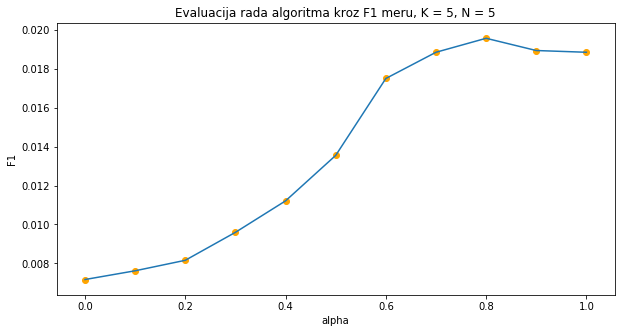

In [456]:
plt.figure(figsize = (10, 5))
plt.title('Evaluacija rada algoritma kroz F1 meru, K = 5, N = 5')
plt.plot([element[0] for element in evaluations], [element[1] for element in evaluations])
plt.scatter([element[0] for element in evaluations], [element[1] for element in evaluations], color = 'orange')
plt.xlabel('alpha')
plt.ylabel('F1')
plt.show()

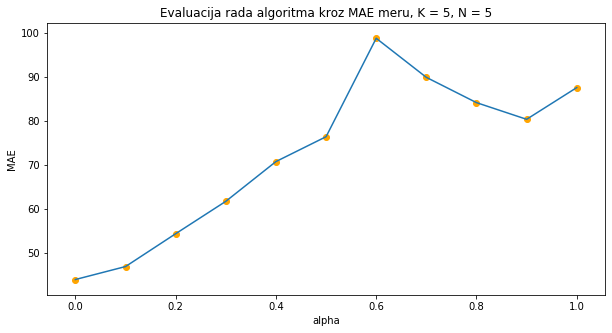

In [457]:
plt.figure(figsize = (10, 5))
plt.title('Evaluacija rada algoritma kroz MAE meru, K = 5, N = 5')
plt.plot([element[0] for element in evaluations], [element[2] for element in evaluations])
plt.scatter([element[0] for element in evaluations], [element[2] for element in evaluations], color = 'orange')
plt.xlabel('alpha')
plt.ylabel('MAE')
plt.show()

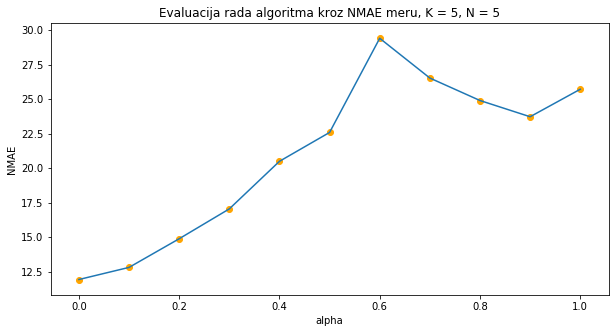

In [458]:
plt.figure(figsize = (10, 5))
plt.title('Evaluacija rada algoritma kroz NMAE meru, K = 5, N = 5')
plt.plot([element[0] for element in evaluations], [element[3] for element in evaluations])
plt.scatter([element[0] for element in evaluations], [element[3] for element in evaluations], color = 'orange')
plt.xlabel('alpha')
plt.ylabel('NMAE')
plt.show()